# Load Dependencies and Check GPU Status

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import numpy as np

# check if GPU is recognized (tensorflow GPU)
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Build Dataloading Function

In [2]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## Plot Raw Data Wave

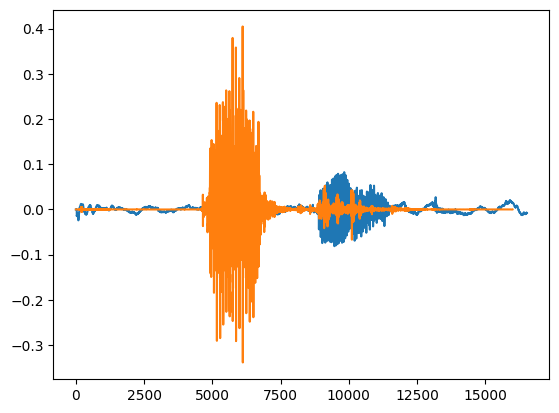

In [65]:
# raw data
BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/BadWords/fuck/tev (1).wav")
NOT_BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/NotBadWords/backward(1).wav")

wave = load_wav_16k_mono(BAD_FILE)
nwave = load_wav_16k_mono(NOT_BAD_FILE)

plt.plot(wave)
plt.plot(nwave)
plt.show()

## Plot Normalized Wave

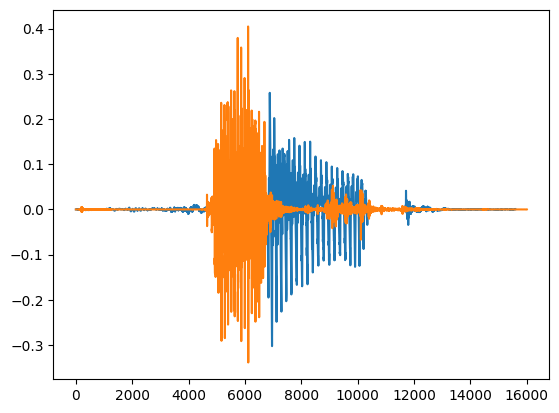

In [70]:
# normalized data
BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/BadWords/fuck_comp/tevin (1).wav")
NOT_BAD_FILE = os.path.join("C:/Users/jreye/ML_DATA/NotBadWords/NotBad_comp/backward(1).wav")

wave = load_wav_16k_mono(BAD_FILE)
nwave = load_wav_16k_mono(NOT_BAD_FILE)

plt.plot(wave)
plt.plot(nwave)
plt.show()

# Create TensorFlow Dataset

In [5]:
# define paths to positive and negative data
NOT_BAD = os.path.join("C:/Users/jreye/ML_DATA/ML_dataset/notBad") 
FUCK = os.path.join("C:/Users/jreye/ML_DATA/ML_dataset/fuck") 
SHIT = os.path.join("C:/Users/jreye/ML_DATA/ML_dataset/shit") 

# Create multi-classification datasets with correct label for categorical classification (float and one-hot encoded)
not_bad = tf.data.Dataset.list_files(NOT_BAD+'\*.wav').map(lambda x: (x, tf.constant([1, 0, 0], dtype=tf.float32))) 
fuck = tf.data.Dataset.list_files(FUCK+'\*.wav').map(lambda x: (x, tf.constant([0, 1, 0], dtype=tf.float32))) 
shit = tf.data.Dataset.list_files(SHIT+'\*.wav').map(lambda x: (x, tf.constant([0, 0, 1], dtype=tf.float32))) 

# Concatenate datasets together
data = not_bad.concatenate(fuck)
data = data.concatenate(shit)

# Print size of each class
print("Size of not_bad dataset: " + repr(len(not_bad)))
print("Size of fuck dataset   : " + repr(len(fuck)))
print("Size of shit dataset   : " + repr(len(shit)))

# for debugging
#list(fuck.as_numpy_iterator())

Size of not_bad dataset: 1850
Size of fuck dataset   : 719
Size of shit dataset   : 618


## Determine Average Length of Sample

In [71]:
# calculate wave cycle length
lengths = []

# not bad files
for file in os.listdir(os.path.join(NOT_BAD)):
     tensor_wave = load_wav_16k_mono(os.path.join(NOT_BAD, file))
     lengths.append(len(tensor_wave))

# fuck files
for file in os.listdir(os.path.join(FUCK)):
     tensor_wave = load_wav_16k_mono(os.path.join(FUCK, file))
     lengths.append(len(tensor_wave))
    
# shit files
for file in os.listdir(os.path.join(SHIT)):
     tensor_wave = load_wav_16k_mono(os.path.join(SHIT, file))
     lengths.append(len(tensor_wave))

In [72]:
# calculate mean
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=17078>

In [73]:
# calculate min
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=4458>

In [74]:
# calculate max
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=29907>

In [75]:
# ave length of bad word
tf.math.reduce_mean(lengths)/16000

<tf.Tensor: shape=(), dtype=float64, numpy=1.067375>

In [76]:
# min length of bad word
tf.math.reduce_min(lengths)/16000

<tf.Tensor: shape=(), dtype=float64, numpy=0.278625>

In [77]:
# max length of bad word
tf.math.reduce_max(lengths)/16000

<tf.Tensor: shape=(), dtype=float64, numpy=1.8691875>

# Build Preprocessing Function to Convert to Spectrogram

In [13]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:25000] # 25000 sample length (can make smaller to reduce processing time but will affect accuracy)
    zero_padding = tf.zeros([25000] - tf.shape(wav), dtype=tf.float32) 
    wav = tf.concat([zero_padding, wav],0) # pad clips longer than 25000 samples with zeros
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32) # short time fourier transform
    spectrogram = tf.abs(spectrogram) 
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

[0. 0. 1.]


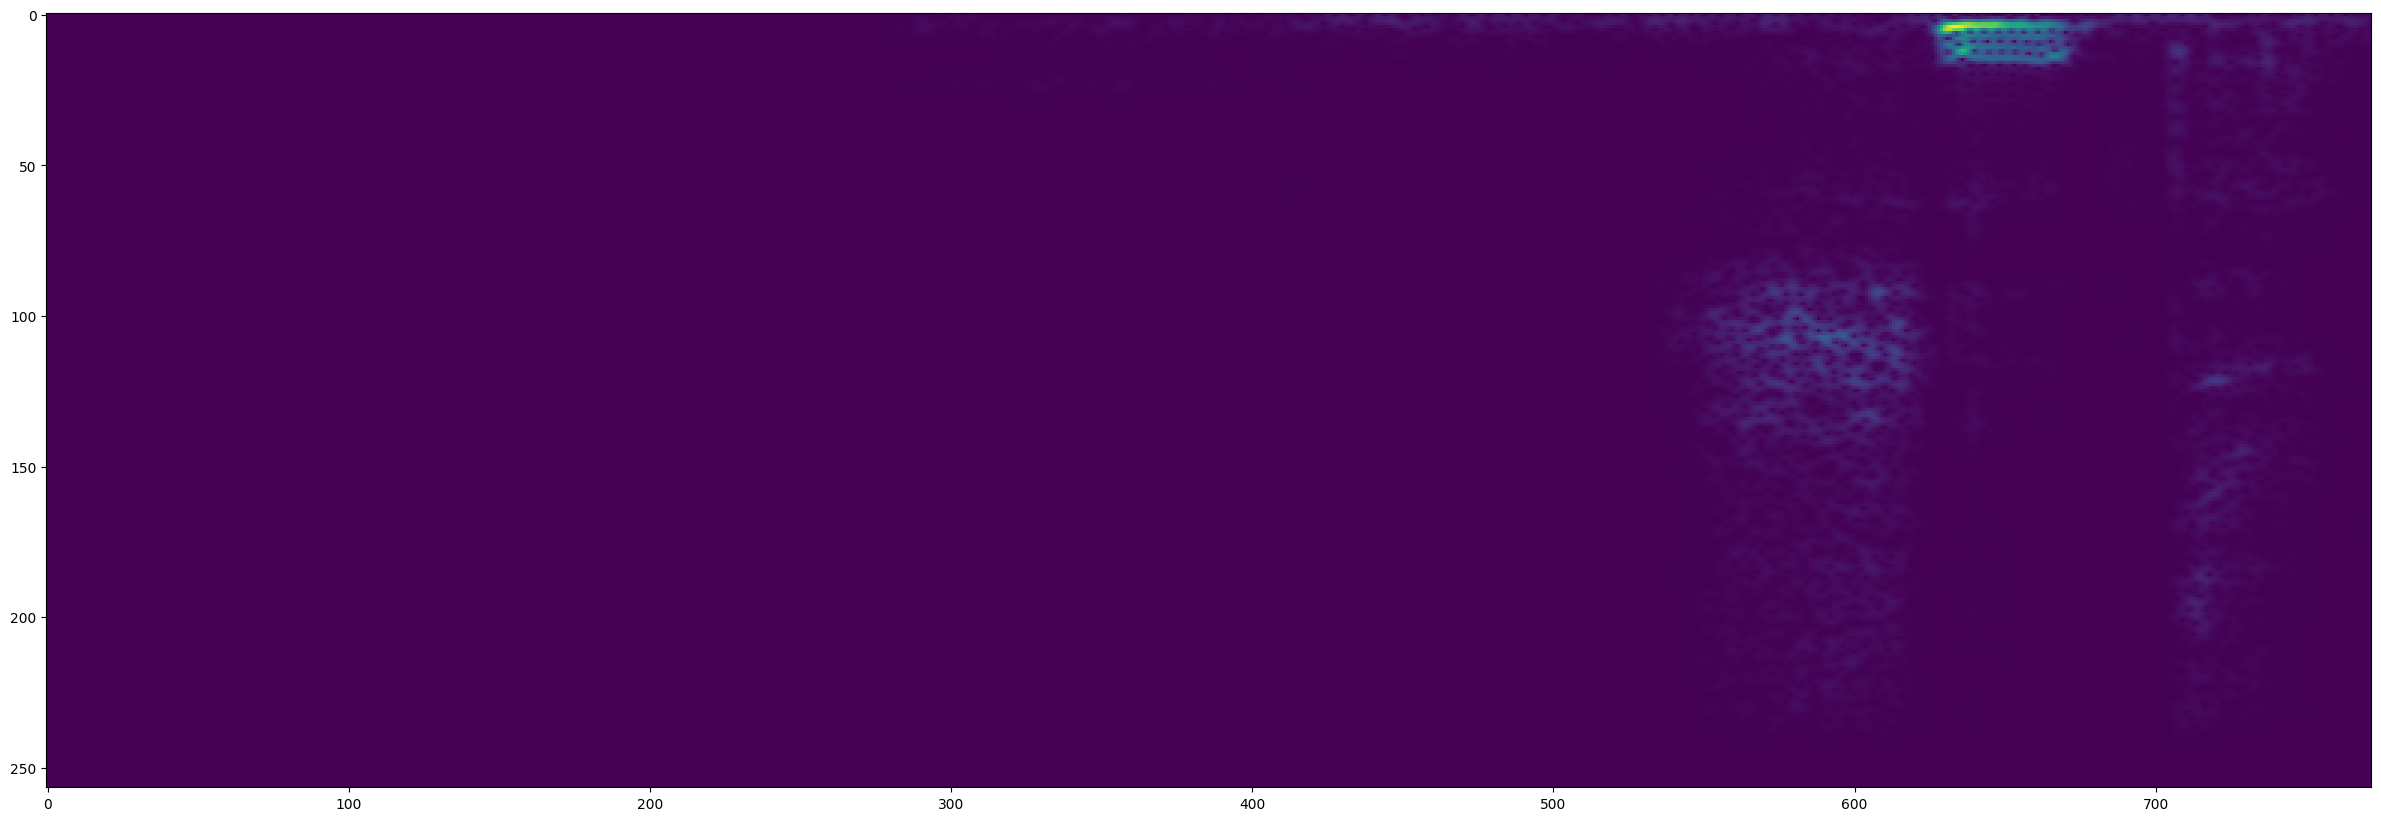

In [14]:
# test out the function and visualize the spectrogram (shit)
filepath, label = shit.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
print(label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Create Training and Testing Partitions

In [ ]:
# Create TensorFlow data pipeline

data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=5000)
data = data.batch(16)
data = data.prefetch(16)

In [ ]:
# Calculate values for train/test split (manual since we're not using SKLearn)

totalSamples = len(data)
seventyPercent = len(data) * 0.7
thirtyPercent = len(data) * 0.3

print("Total Samples: %d" % totalSamples)
print("70 percent of total: %d" % seventyPercent)
print("30 percent of total: %d" % thirtyPercent)

In [ ]:
# Manually train/test split using calculated values

# Take 140 samples for the training set
train = data.take(seventyPercent)

# Skip the first 140 samples, then take the remaining 60
# for the testing set
test = data.skip(seventyPercent).take(thirtyPercent)

# Build Deep Learning Model

In [ ]:
# Import dependencies
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, Activation
from tensorflow.keras.callbacks import TensorBoard # to view statistics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, Recall, Precision
from tensorflow.keras.models import save_model, load_model

import time